In [1]:
# ============================================
# A) SETTING UP THE ENVIRONMENT
# ============================================
import numpy as np
from collections import defaultdict
import random

# Board encoding:  1 = 'X', -1 = 'O', 0 = empty
# We'll let the agent learn as 'X' by default.


In [3]:
# ============================================
# B) DEFINING THE TIC-TAC-TOE GAME
# ============================================
class TicTacToeEnv:
    def __init__(self, first_player=1):
        self.first_player = first_player  # 1 for 'X', -1 for 'O'
        self.reset()

    def reset(self):
        self.board = np.zeros(9, dtype=int)   # 3x3 flattened
        self.current_player = self.first_player
        self.done = False
        self.winner = 0  # 1, -1, or 0 for draw/ongoing
        return self.get_state()

    def get_state(self):
        # Return immutable state representation (tuple) for Q-table
        return tuple(self.board.tolist())

    def available_actions(self):
        return [i for i, v in enumerate(self.board) if v == 0]

    def check_winner(self):
        b = self.board.reshape(3,3)
        lines = [
            b[0,:], b[1,:], b[2,:],  # rows
            b[:,0], b[:,1], b[:,2],  # cols
            b.diagonal(), np.fliplr(b).diagonal()  # diagonals
        ]
        for line in lines:
            s = line.sum()
            if s == 3:  return 1
            if s == -3: return -1
        if np.all(self.board != 0):
            return 0  # draw
        return None   # game not finished

    def step(self, action):
        """
        Apply 'action' for current_player.
        Returns: next_state, reward, done, info
        Reward here is neutral (0); we decide final rewards after terminal.
        """
        if self.done:
            raise ValueError("Game is over. Call reset().")
        if action not in self.available_actions():
            raise ValueError(f"Illegal action {action}")

        self.board[action] = self.current_player

        result = self.check_winner()
        if result is not None:  # terminal
            self.done = True
            self.winner = result
            # winner: 1 (X), -1 (O), 0 (draw)
            return self.get_state(), 0.0, True, {"winner": self.winner}

        # Switch player and continue
        self.current_player *= -1
        return self.get_state(), 0.0, False, {}
    
    def render(self):
        sym = {1: 'X', -1: 'O', 0: ' '}
        b = np.array([sym[v] for v in self.board]).reshape(3,3)
        print("\n".join([" | ".join(row) for row in b]))
        print("-"*9)


In [5]:
# ============================================
# C) BUILDING THE REINFORCEMENT LEARNING MODEL (Q-Learning)
# ============================================
class QAgent:
    def __init__(self, symbol=1, alpha=0.5, gamma=0.99, epsilon=1.0, epsilon_min=0.05, epsilon_decay=0.9995):
        """
        symbol: 1 ('X') or -1 ('O') — which side the agent controls during training/eval
        """
        self.symbol = symbol
        self.Q = defaultdict(lambda: np.zeros(9, dtype=float))  # Q[state][action]
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

    def select_action(self, state, available_actions):
        # ε-greedy over available actions only
        if (np.random.rand() < self.epsilon):
            return random.choice(available_actions)
        qvals = self.Q[state].copy()
        # Mask illegal actions to -inf so they are never chosen by argmax
        mask = np.full(9, -np.inf)
        mask[available_actions] = qvals[available_actions]
        return int(mask.argmax())

    def update(self, s, a, r, s_next, available_next, done):
        q_sa = self.Q[s][a]
        if done:
            target = r
        else:
            # Look ahead only on legal moves
            next_q = self.Q[s_next]
            if len(available_next) == 0:
                target = r
            else:
                target = r + self.gamma * np.max(next_q[available_next])
        self.Q[s][a] += self.alpha * (target - q_sa)

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)


In [7]:
# Utility: play a single training episode where agent plays as 'X' (1) or 'O' (-1) vs random opponent.
def play_training_episode(env, agent, opponent="random"):
    """
    Returns (result, steps) where result is:
      1 if X wins, -1 if O wins, 0 if draw
    Reward design from AGENT perspective:
      +1 for agent win, -1 for agent loss, 0 for draw; 0 for intermediate steps.
    """
    s = env.reset()
    total_steps = 0

    while True:
        if env.current_player == agent.symbol:
            # Agent's turn
            actions = env.available_actions()
            a = agent.select_action(s, actions)
            s_next, _, done, info = env.step(a)
            total_steps += 1

            # If terminal after agent's move
            if done:
                result = info["winner"]
                # Reward from agent's perspective
                r = 1.0 if result == agent.symbol else (0.0 if result == 0 else -1.0)
                agent.update(s, a, r, s_next, [], done=True)
                agent.decay_epsilon()
                return result, total_steps

            # Not terminal -> opponent will move; we give intermediate reward 0
            # Update with r=0 and s' is the *state before opponent moves*? 
            # Better: wait until after opponent acts to compute next state.
            # We'll store s,a and update after opponent action using s_next2.

            # Opponent move
            if opponent == "random":
                opp_actions = env.available_actions()
                opp_a = random.choice(opp_actions)
            else:
                # You can plug in a smarter opponent policy here
                opp_actions = env.available_actions()
                opp_a = random.choice(opp_actions)

            s_mid = s_next  # state after agent move
            s_next2, _, done2, info2 = env.step(opp_a)
            total_steps += 1

            if done2:
                result = info2["winner"]
                # If opponent wins, that's -1; if draw, 0
                r = 1.0 if result == agent.symbol else (0.0 if result == 0 else -1.0)
                # Update from (s, a) -> terminal
                agent.update(s, a, r, s_next2, [], done=True)
                agent.decay_epsilon()
                return result, total_steps
            else:
                # Non-terminal -> update for (s, a) using s_next2
                next_actions = env.available_actions()
                agent.update(s, a, 0.0, s_next2, next_actions, done=False)
                s = s_next2  # continue from the post-opponent state

        else:
            # If somehow it's opponent's turn first (e.g., agent is 'O')
            if opponent == "random":
                opp_actions = env.available_actions()
                opp_a = random.choice(opp_actions)
            else:
                opp_actions = env.available_actions()
                opp_a = random.choice(opp_actions)
            s_next, _, done, info = env.step(opp_a)
            total_steps += 1
            if done:
                # Agent receives loss if opponent wins; draw if 0
                result = info["winner"]
                # No Q update here (agent didn't act yet), just end
                agent.decay_epsilon()
                return result, total_steps
            s = s_next


In [9]:
# ============================================
# D) TRAINING THE MODEL
# ============================================
env = TicTacToeEnv(first_player=1)      # 'X' starts
agent = QAgent(symbol=1,                # agent plays 'X'
               alpha=0.5, gamma=0.99,
               epsilon=1.0, epsilon_min=0.05, epsilon_decay=0.9995)

episodes = 50000
results = {1:0, -1:0, 0:0}
track = []  # moving average of win rate

win_count = 0
window = 1000

for ep in range(1, episodes+1):
    result, steps = play_training_episode(env, agent, opponent="random")
    results[result] += 1
    if result == agent.symbol:
        win_count += 1

    if ep % window == 0:
        track.append(win_count / window)
        win_count = 0

print("Training complete.")
print(f"Totals over {episodes} episodes → X wins: {results[1]}, O wins: {results[-1]}, Draws: {results[0]}")


Training complete.
Totals over 50000 episodes → X wins: 47368, O wins: 1239, Draws: 1393


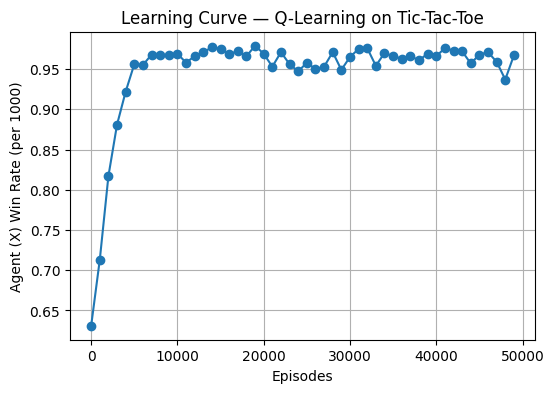

In [11]:
# (Optional) plot learning curve (moving average win rate for the agent)
try:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6,4))
    plt.plot(np.arange(len(track))*1000, track, marker='o')
    plt.xlabel("Episodes")
    plt.ylabel("Agent (X) Win Rate (per 1000)")
    plt.title("Learning Curve — Q-Learning on Tic-Tac-Toe")
    plt.grid(True)
    plt.show()
except Exception as e:
    print("Plot skipped:", e)


In [13]:
# ============================================
# E) TESTING THE MODEL
# ============================================
def play_vs_random(agent, games=1000, as_symbol=1):
    """
    Evaluate trained agent vs random player.
    Returns dict of outcomes.
    """
    env = TicTacToeEnv(first_player=1)
    agent.symbol = as_symbol
    # Freeze exploration for testing
    eps_backup = agent.epsilon
    agent.epsilon = 0.0

    stats = {1:0, -1:0, 0:0}
    for _ in range(games):
        s = env.reset()
        # If agent is 'O', let X (random) maybe start
        while True:
            if env.current_player == agent.symbol:
                actions = env.available_actions()
                a = agent.select_action(s, actions)
                s, _, done, info = env.step(a)
                if done:
                    stats[info["winner"]] += 1
                    break
            else:
                # random opponent
                actions = env.available_actions()
                a = random.choice(actions)
                s, _, done, info = env.step(a)
                if done:
                    stats[info["winner"]] += 1
                    break

    agent.epsilon = eps_backup
    return stats

test_results_X = play_vs_random(agent, games=1000, as_symbol=1)
print("Test as X vs Random →", test_results_X, " (X wins / O wins / Draw)")

# Also try as 'O' (second player)
test_results_O = play_vs_random(agent, games=1000, as_symbol=-1)
print("Test as O vs Random →", test_results_O, " (X wins / O wins / Draw)")


Test as X vs Random → {1: 994, -1: 0, 0: 6}  (X wins / O wins / Draw)
Test as O vs Random → {1: 535, -1: 431, 0: 34}  (X wins / O wins / Draw)
